In [1]:
import torch
from torch import nn
from d2l import torch as d2l

ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

# 11.8.2. Patch Embedding

In [ ]:
class PatchEmbedding(nn.Module):
    def __init__(self, img_size=96, patch_size=16, num_hiddens=512):
        super().__init__()
        def _make_tuple(x):
            if not isinstance(x, (list, tuple)):
                return (x, x)
            return x
        img_size, patch_size = _make_tuple(img_size), _make_tuple(patch_size)
        self.num_patches = (img_size[0] // patch_size[0]) * (img_size[1] // patch_size[1])
        self.conv = nn.LazyConv2d(num_hiddens, kernel_size=patch_size, stride=patch_size)

    def forward(self, X):
        # Output shape: (batch_size, no. of patches, no. of channels)
        return self.conv(X).flatten(2).transpose(1, 2)

In [ ]:
img_size, patch_size, num_hiddens, batch_size = 96, 16, 512, 4
patch_emb = PatchEmbedding(img_size, patch_size, num_hiddens)
X = torch.zeros(batch_size, 3, img_size, img_size)
d2l.check_shape(patch_emb(X), (batch_size, (img_size//patch_size)**2, num_hiddens))

# 11.8.3. Vision Transformer Encoder

In [ ]:
class ViTMLP(nn.Module):
    def __init__(self, mlp_num_hiddens, mlp_num_outputs, dropout=0.5):
        super().__init__()
        self.dense1 = nn.LazyLinear(mlp_num_hiddens)
        self.gelu = nn.GELU()
        self.dropout1 = nn.Dropout(dropout)
        self.dense2 = nn.LazyLinear(mlp_num_outputs)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, x):
        return self.dropout2(self.dense2(self.dropout1(self.gelu(self.dense1(x)))))

In [ ]:
class ViTBlock(nn.Module):
    def __init__(self, num_hiddens, norm_shape, mlp_num_hiddens, num_heads, dropout, use_bias=False):
        super().__init__()
        self.ln1 = nn.LayerNorm(norm_shape)
        self.attention = d2l.MultiHeadAttention(num_hiddens, num_heads, dropout, use_bias)
        self.ln2 = nn.LayerNorm(norm_shape)
        self.mlp = ViTMLP(mlp_num_hiddens, num_hiddens, dropout)

    def forward(self, X, valid_lens=None):
        X = X + self.attention(*([self.ln1(X)] * 3), valid_lens)
        # Equals to self.attention(self.ln1(X), self.ln1(X), self.ln1(X), valid_lens)
        return X + self.mlp(self.ln2(X))

In [ ]:
X = torch.ones((2, 100, 24))
encoder_blk = ViTBlock(24, 24, 48, 8, 0.5)
encoder_blk.eval()
d2l.check_shape(encoder_blk(X), X.shape)

d:\_Software\miniconda3\envs\d2l\lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


# 11.8.4. Putting It All Together

In [ ]:
class ViT(d2l.Classifier):
    """Vision Transformer."""
    def __init__(self, img_size, patch_size, num_hiddens, mlp_num_hiddens, num_heads, num_blks, emb_dropout, blk_dropout, lr=0.1, use_bias=False, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.patch_embedding = PatchEmbedding(img_size, patch_size, num_hiddens)
        self.cls_token = nn.Parameter(torch.zeros(1, 1, num_hiddens))
        num_steps = self.patch_embedding.num_patches + 1  # Add the cls token
        self.pos_embedding = nn.Parameter(torch.randn(1, num_steps, num_hiddens))
        self.dropout = nn.Dropout(emb_dropout)
        self.blks = nn.Sequential()
        for i in range(num_blks):
            self.blks.add_module(f"{i}", ViTBlock(num_hiddens, num_hiddens, mlp_num_hiddens, num_heads, blk_dropout, use_bias))
        self.head = nn.Sequential(nn.LayerNorm(num_hiddens), nn.Linear(num_hiddens, num_classes))

    def forward(self, X):
        X = self.patch_embedding(X)
        X = torch.cat((self.cls_token.expand(X.shape[0], -1, -1), X), 1)  # ?
        X = self.dropout(X + self.pos_embedding)
        for blk in self.blks:
            X = blk(X)
        return self.head(X[:, 0])

# 11.8.5. Training

KeyboardInterrupt: 

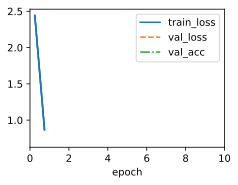

In [ ]:
img_size, patch_size = 96, 16
num_hiddens, mlp_num_hiddens, num_heads, num_blks = 512, 2048, 8, 2
emb_dropout, blk_dropout, lr = 0.1, 0.1, 0.1
model = ViT(img_size, patch_size, num_hiddens, mlp_num_hiddens, num_heads, num_blks, emb_dropout, blk_dropout, lr)
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128, resize=(img_size, img_size))
trainer.fit(model, data)

In [ ]:
# Check PyTorch / d2l GPU availability
import torch
from d2l import torch as d2l

print("torch.cuda.is_available():", torch.cuda.is_available())
print("torch.cuda.device_count():", torch.cuda.device_count())
if torch.cuda.is_available():
    print("current device idx:", torch.cuda.current_device())
    print("device name:", torch.cuda.get_device_name(0))
print("d2l.try_gpu():", d2l.try_gpu())

torch.cuda.is_available(): False
torch.cuda.device_count(): 0
d2l.try_gpu(): cpu


In [ ]:
# run in the same environment/kernel you use for the notebook
import torch
print("torch:", torch.__version__)
print("torch.version.cuda:", torch.version.cuda)
print("torch.cuda.is_available():", torch.cuda.is_available())
print("torch.cuda.device_count():", torch.cuda.device_count())

torch: 2.0.0+cpu
torch.version.cuda: None
torch.cuda.is_available(): False
torch.cuda.device_count(): 0
